In [1]:
# this version accepts all images, both good and bad, the bad ones have labels -1, -1
# this notebook has just quick CNN training
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
tf.__version__

'1.11.0'

In [3]:
img_data = np.load('data/subImgSet.npy')
img_data.shape

(20000, 104, 104, 1)

In [4]:
lab_data1 = np.load('data/labels1Set.npy')
print(lab_data1.shape)

(20000,)


In [5]:
lab_data2 = np.load('data/labels2Set.npy')
print(lab_data2.shape)

(20000,)


In [6]:
test_mask = np.load('data/testMaskSet.npy')
print(test_mask.shape)

(20000,)


In [7]:
# dic = "1234567ABCDEFGJKLMPQRTUVY" -- from Anka
suit_dict = {'1':0, '2':1, '3':2, '4':3, '5':4, '6':5, '7':6, 'A':7, 'B':8, 'C':9, 'D':10, 'E':11, 'F':12, 'G':13, 'J':14, 
           'K':15, 'L':16, 'M':17, 'P':18, 'Q':19, 'R':20, 'T':21, 'U':22, 'V':23, 'Y':24}
inv_suit_dict = {v: k for k, v in suit_dict.items()}

In [8]:
np.min(lab_data1), np.max(lab_data1)

(0, 25)

In [9]:
np.min(lab_data2), np.max(lab_data2)

(0, 25)

In [10]:
tst1 = np.histogram(lab_data1, bins=25)
print(tst1)
tst2 = np.histogram(lab_data2, bins=25)
print(tst2)

(array([16306,   150,   163,   129,    75,   123,   316,   324,   181,
         123,    58,   125,   234,   330,    25,   183,    67,    92,
         234,   143,   123,    61,    85,   169,   181], dtype=int64), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]))
(array([16306,   130,   127,   138,   152,   169,   154,   138,   134,
         151,   145,   162,   173,   164,   166,   149,   167,   129,
         129,   126,   149,   178,   152,   139,   273], dtype=int64), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]))


In [11]:
assert(lab_data1.shape[0] == img_data.shape[0] and lab_data1.shape[0] == lab_data2.shape[0])

In [12]:
def vis_data(offset):
   plt.figure(figsize=(16,10))
   for i in range(6*11):
       plt.subplot(6,11,i+1)
       plt.xticks([])
       plt.yticks([])
       plt.grid(False)
       plt.imshow(img_data[offset + i, :, :, 0], cmap=plt.cm.gray)
       if lab_data1[offset + i] == 0:
           plt.xlabel("None")
       else:
           plt.xlabel(str(inv_suit_dict[lab_data1[offset + i] - 1]) + ", " + str(inv_suit_dict[lab_data2[offset + i] - 1])) 

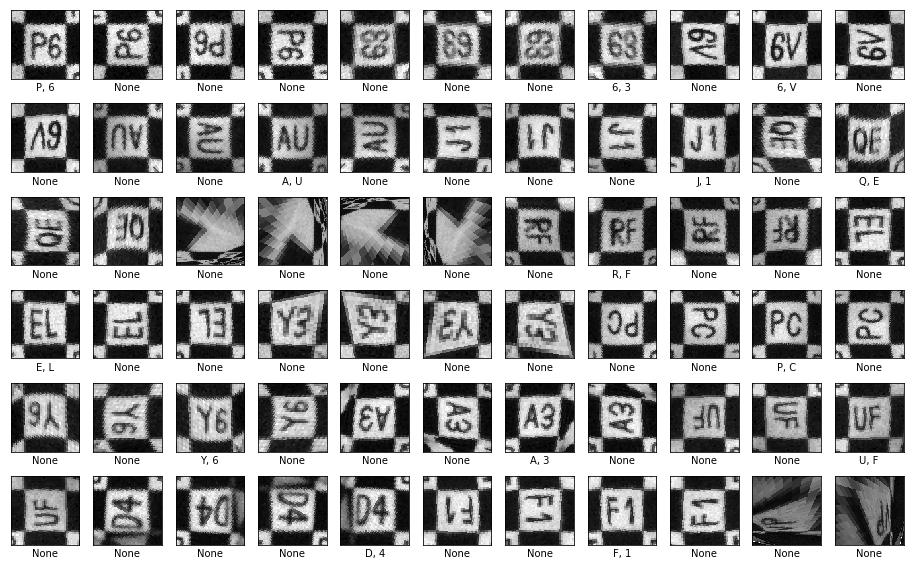

In [13]:
# visualize some of the data
vis_data(19000)

(array([67878257., 24472233., 19464187., 30070073., 19641448., 23420424.,
        21753624.,  8252330.,  1193823.,   173601.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

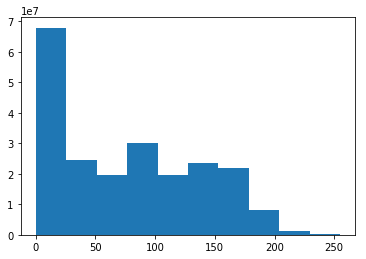

In [14]:
plt.hist(img_data.flatten())

In [15]:
np.histogram(test_mask)

(array([17248,     0,     0,     0,     0,     0,     0,     0,     0,
         2752], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [16]:
train_mask = np.array(1 - test_mask, dtype=bool)

In [17]:
train_images = img_data[train_mask, :, :, :]
train_labels1 = lab_data1[train_mask]
train_labels2 = lab_data2[train_mask]

In [18]:
test_images = img_data[test_mask, :, :, :]
test_labels1 = lab_data1[test_mask]
test_labels2 = lab_data2[test_mask]

In [19]:
train_samples = train_images.shape[0]
test_samples = test_images.shape[0]
print(train_samples, test_samples)

17248 2752


In [20]:
train_images.shape, train_labels1.shape, train_labels2.shape

((17248, 104, 104, 1), (17248,), (17248,))

In [21]:
test_images.shape, test_labels1.shape, test_labels2.shape

((2752, 104, 104, 1), (2752,), (2752,))

In [22]:
#train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1) / 255
#test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1) / 255

In [23]:
np.min(train_images), np.max(train_images)

(0, 255)

In [24]:
train_images.shape, test_images.shape

((17248, 104, 104, 1), (2752, 104, 104, 1))

In [25]:
#sess.close()

In [26]:
#define compute graph in tensorflow to evaluate the cost function
tf.reset_default_graph()
rseed2 = 123
np.random.seed(rseed2)
tf.set_random_seed(rseed2)
#imgs_ph = tf.placeholder(tf.float32, [None, 104, 104, 1])
imgs_ph = tf.placeholder(tf.uint8, [None, 104, 104, 1])
labels1_ph = tf.placeholder(tf.int32, [None])
labels2_ph = tf.placeholder(tf.int32, [None])
learnrate_ph = tf.placeholder(tf.float32, None)
training_ph = tf.placeholder(tf.bool)
pkeep_ph = tf.placeholder(tf.float32)

In [27]:
# initialize variables for...
# ... 1) convolution kernels
num_classes = 26

num_filters1 = 12
num_filters2 = 25
num_filters3 = 50
W1 = tf.get_variable("W1", shape=[5, 5, 1, num_filters1], initializer=tf.initializers.glorot_normal())
b1 = tf.get_variable("b1", shape=[num_filters1], initializer=tf.initializers.zeros())
W2 = tf.get_variable("W2", shape=[5, 5, num_filters1, num_filters2], initializer=tf.initializers.glorot_normal())
b2 = tf.get_variable("b2", shape=[num_filters2], initializer=tf.initializers.zeros())
W3 = tf.get_variable("W3", shape=[5, 5, num_filters2, num_filters3], initializer=tf.initializers.glorot_normal())
b3 = tf.get_variable("b3", shape=[num_filters3], initializer=tf.initializers.zeros())

num_fc1 = 4050
num_fc2 = 120
num_fc3 = 80
num_fc4 = 50
# ... 2) dense layers: fork 1 (first character prediction)
W4a = tf.get_variable("W4a", shape=[num_fc1, num_fc2], initializer=tf.initializers.glorot_normal())
b4a = tf.get_variable("b4a", shape=[num_fc2], initializer=tf.initializers.zeros())
W5a = tf.get_variable("W5a", shape=[num_fc2, num_fc3], initializer=tf.initializers.glorot_normal())
b5a = tf.get_variable("b5a", shape=[num_fc3], initializer=tf.initializers.zeros())
W6a = tf.get_variable("W6a", shape=[num_fc3, num_fc4], initializer=tf.initializers.glorot_normal())
b6a = tf.get_variable("b6a", shape=[num_fc4], initializer=tf.initializers.zeros())
W7a = tf.get_variable("W7a", shape=[num_fc4, num_classes], initializer=tf.initializers.glorot_normal())
b7a = tf.get_variable("b7a", shape=[num_classes], initializer=tf.initializers.zeros())
# ... 3) dense layers: fork 2 (second character prediction)
W4b = tf.get_variable("W4b", shape=[num_fc1, num_fc2], initializer=tf.initializers.glorot_normal())
b4b = tf.get_variable("b4b", shape=[num_fc2], initializer=tf.initializers.zeros())
W5b = tf.get_variable("W5b", shape=[num_fc2, num_fc3], initializer=tf.initializers.glorot_normal())
b5b = tf.get_variable("b5b", shape=[num_fc3], initializer=tf.initializers.zeros())
W6b = tf.get_variable("W6b", shape=[num_fc3, num_fc4], initializer=tf.initializers.glorot_normal())
b6b = tf.get_variable("b6b", shape=[num_fc4], initializer=tf.initializers.zeros())
# note the num_classes - 1 below:
W7b = tf.get_variable("W7b", shape=[num_fc4, num_classes - 1], initializer=tf.initializers.glorot_normal())
b7b = tf.get_variable("b7b", shape=[num_classes - 1], initializer=tf.initializers.zeros())
#W4c = tf.get_variable("W4c", shape=[num_fc1, num_fc2], initializer=tf.initializers.glorot_normal())
#b4c = tf.get_variable("b4c", shape=[num_fc2], initializer=tf.initializers.zeros())
#W5c = tf.get_variable("W5c", shape=[num_fc2, num_fc3], initializer=tf.initializers.glorot_normal())
#b5c = tf.get_variable("b5c", shape=[num_fc3], initializer=tf.initializers.zeros())
#W6c = tf.get_variable("W6c", shape=[num_fc3, num_fc4], initializer=tf.initializers.glorot_normal())
#b6c = tf.get_variable("b6c", shape=[num_fc4], initializer=tf.initializers.zeros())
#W7c = tf.get_variable("W7c", shape=[num_fc4, 1], initializer=tf.initializers.glorot_normal())
#b7c = tf.get_variable("b7c", shape=[1], initializer=tf.initializers.zeros())

In [28]:
assert(num_classes == max(lab_data1) + 1)

In [29]:
# build compute graph evaluating the CNN
conv1 = tf.nn.relu(tf.layers.batch_normalization(tf.nn.conv2d(imgs_ph / 255, W1, strides = [1,1,1,1], padding = 'VALID'), 
                                                 axis=[1,2,3], training=training_ph))
#conv1 = tf.nn.relu(tf.nn.conv2d(imgs_ph, W1, strides = [1,1,1,1], padding = 'VALID'))
pool1 = tf.nn.dropout(tf.nn.max_pool(conv1, ksize = [1,2,2,1], strides=[1,2,2,1], padding = 'VALID'), pkeep_ph)
conv2 = tf.nn.relu(tf.layers.batch_normalization(tf.nn.conv2d(pool1, W2, strides = [1,1,1,1], padding = 'VALID'), 
                                                 axis=[1,2,3], training=training_ph))
#conv2 = tf.nn.relu(tf.nn.conv2d(pool1, W2, strides = [1,1,1,1], padding = 'VALID'))
pool2 = tf.nn.dropout(tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides=[1,2,2,1], padding = 'VALID'), pkeep_ph)
conv3 = tf.nn.relu(tf.layers.batch_normalization(tf.nn.conv2d(pool2, W3, strides = [1,1,1,1], padding = 'VALID'), 
                                                 axis=[1,2,3], training=training_ph))
#conv3 = tf.nn.relu(tf.nn.conv2d(pool2, W3, strides = [1,1,1,1], padding = 'VALID'))
pool3 = tf.nn.dropout(tf.nn.max_pool(conv3, ksize = [1,2,2,1], strides=[1,2,2,1], padding = 'VALID'), pkeep_ph)
flat1 = tf.reshape(pool3, [-1, num_fc1])
bnorm_axis = -1
dens1a = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(flat1, W4a), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens2a = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens1a, W5a), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens3a = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens2a, W6a), axis=bnorm_axis, training=training_ph)), 1.0)
dens4a = tf.layers.batch_normalization(tf.matmul(dens3a, W7a), axis=bnorm_axis, training=training_ph)

dens1b = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(flat1, W4b), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens2b = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens1b, W5b), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens3b = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens2b, W6b), axis=bnorm_axis, training=training_ph)), 1.0)
dens4b_partial = tf.layers.batch_normalization(tf.matmul(dens3b, W7b), axis=bnorm_axis, training=training_ph)
# hack: copy the first column of dens4a into dens4b
d4a_s1, d4a_s2 = tf.split(dens4a, [1,25], 1)
dens4b = tf.concat([d4a_s1, dens4b_partial], axis=1)

#crent = tf.nn.sigmoid_cross_entropy_with_logits(labels = goodness_ph, logits = dens4c)
crenta = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels1_ph, logits = dens4a)
crentb = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels2_ph, logits = dens4b)
crent = crenta + crentb
loss_fun = tf.reduce_mean(crent)
# for batch-norm updates:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate = learnrate_ph).minimize(loss_fun)

predictions1 = tf.equal(tf.argmax(dens4a, 1), tf.cast(labels1_ph, tf.int64))
predictions2 = tf.equal(tf.argmax(dens4b, 1), tf.cast(labels2_ph, tf.int64))
predictions = tf.logical_and(predictions1, predictions2)
accuracy = tf.reduce_mean(tf.cast(predictions, tf.float32))
#predictions_goodness = tf.math.greater(dens4c, 0.0)
#correct_preds_g = tf.equal(predictions_goodness, tf.cast(goodness_ph, tf.bool))
#accuracy = tf.reduce_mean(tf.cast(correct_preds_g, tf.float32))

In [30]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [31]:
batch_size = 400
learning_rate = 0.001
num_batches = int(train_images.shape[0] / batch_size)
print('num_batches =', num_batches)
# discard training data that overflow the last minibatch
trunc_train_images = train_images[:num_batches*batch_size,:,:,:]
trunc_train_labels1 = train_labels1[:num_batches*batch_size]
trunc_train_labels2 = train_labels2[:num_batches*batch_size]
#trunc_train_goodness = train_goodness[:num_batches*batch_size]

num_batches = 43


In [34]:
def train(num_epochs, learning_rate = 0.001, pkeep = 0.65):
    global trunc_train_images, trunc_train_labels1, trunc_train_labels2
    for e in range(num_epochs):
        # randomize the order of training data
        ind_list = [i for i in range(trunc_train_images.shape[0])]
        np.random.shuffle(ind_list)
        trunc_train_images = trunc_train_images[ind_list, :, :, :]
        trunc_train_labels1 = trunc_train_labels1[ind_list]
        trunc_train_labels2 = trunc_train_labels2[ind_list]
        #trunc_train_goodness = trunc_train_goodness[ind_list]

        start_time = time.time()
        for i in range(num_batches):        
            train_dict = {imgs_ph:trunc_train_images[i*batch_size:(i+1)*batch_size,:,:,:], 
                          labels1_ph:trunc_train_labels1[i*batch_size:(i+1)*batch_size],
                          labels2_ph:trunc_train_labels2[i*batch_size:(i+1)*batch_size],
                          learnrate_ph:learning_rate,
                          training_ph:True,
                          pkeep_ph:pkeep}                          
            sess.run(train_step, train_dict)
            #print(e, '/', i)
            # the following stats compute can be removed to speed up training
            #mb_loss, mb_acc = sess.run([loss_fun, accuracy], train_dict)    
            #print(e, '/', i, ': mb_loss = ', mb_loss, ' mb_acc = ', mb_acc)

        loss_train, acc_train = 0.0, 0.0
        for i in range(num_batches):    
            train_dict = {imgs_ph:trunc_train_images[i*batch_size:(i+1)*batch_size,:,:,:], 
                          labels1_ph:trunc_train_labels1[i*batch_size:(i+1)*batch_size],
                          labels2_ph:trunc_train_labels2[i*batch_size:(i+1)*batch_size],
                          learnrate_ph:learning_rate,
                          training_ph:False, pkeep_ph:1.0}
            l_train, a_train = sess.run([loss_fun, accuracy], train_dict)    
            loss_train += l_train
            acc_train += a_train
        end_time = time.time()
        elaps_time = end_time - start_time

        loss_train /= num_batches
        acc_train /= num_batches

        # also compute loss & accuracy on the test set, no need to minibatch that 
        loss_test, acc_test = sess.run([loss_fun, accuracy], {imgs_ph:test_images, labels1_ph:test_labels1, labels2_ph:test_labels2, learnrate_ph:learning_rate, training_ph:False, pkeep_ph:1.0})

        print("%03i (%.2f): ltr = %.6f, atr = %.6f | lts = %.6f, ats = %.6f" % (e, elaps_time, loss_train, acc_train, loss_test, acc_test))
        #print(e, ': loss_train =', loss_train, ' acc_train =', acc_train, 'time =', end_time - start_time)

In [35]:
train(1000)

000 (11.09): ltr = 3.384648, atr = 0.886686 | lts = 3.395519, ats = 0.883358
001 (11.14): ltr = 3.103675, atr = 0.907151 | lts = 3.127405, ats = 0.898983
002 (11.12): ltr = 2.790687, atr = 0.935988 | lts = 2.830627, ats = 0.924782
003 (11.10): ltr = 2.552220, atr = 0.962733 | lts = 2.588669, ats = 0.955669
004 (11.12): ltr = 2.356914, atr = 0.967442 | lts = 2.418346, ats = 0.954215
005 (11.16): ltr = 2.211415, atr = 0.977849 | lts = 2.265368, ats = 0.967297
006 (11.10): ltr = 2.060909, atr = 0.980000 | lts = 2.116714, ats = 0.973474
007 (11.04): ltr = 1.908823, atr = 0.983954 | lts = 1.969116, ats = 0.977471
008 (11.21): ltr = 1.789542, atr = 0.984942 | lts = 1.858849, ats = 0.974927
009 (11.06): ltr = 1.686967, atr = 0.986919 | lts = 1.752557, ats = 0.978924
010 (11.15): ltr = 1.569002, atr = 0.988372 | lts = 1.638823, ats = 0.979651
011 (11.12): ltr = 1.472598, atr = 0.989302 | lts = 1.548851, ats = 0.978924
012 (11.19): ltr = 1.398086, atr = 0.991686 | lts = 1.469057, ats = 0.981831

KeyboardInterrupt: 

In [36]:
#train(10, 0.0001)

In [37]:
#train(40, 0.0003)

In [38]:
# next double check if the test accuracy is correct:

In [39]:
ext_suit_dict = {'0':-1, '1':0, '2':1, '3':2, '4':3, '5':4, '6':5, '7':6, 'A':7, 'B':8, 'C':9, 'D':10, 'E':11, 'F':12, 'G':13, 'J':14, 
           'K':15, 'L':16, 'M':17, 'P':18, 'Q':19, 'R':20, 'T':21, 'U':22, 'V':23, 'Y':24}
inv_ext_suit_dict = {v: k for k, v in ext_suit_dict.items()}

In [40]:
t_dens4a = sess.run(dens4a, {imgs_ph:test_images, labels1_ph:test_labels1, labels2_ph:test_labels1, training_ph:False, pkeep_ph:1.0})

In [41]:
t_predictions1 = np.argmax(t_dens4a, 1)

In [42]:
t_predictions1.shape, test_images.shape[0]

((2752,), 2752)

In [43]:
t_dens4b = sess.run(dens4b, {imgs_ph:test_images, labels1_ph:test_labels1, labels2_ph:test_labels1, training_ph:False, pkeep_ph:1.0})

In [44]:
t_predictions2 = np.argmax(t_dens4b, 1)

In [45]:
t_predictions2

array([0, 0, 7, ..., 0, 0, 0], dtype=int64)

In [46]:
count = 0
for i in range(test_images.shape[0]):    
    if t_predictions1[i] == test_labels1[i] and t_predictions2[i] == test_labels2[i]:
        count = count + 1
print(float(count) / test_images.shape[0])

0.9887354651162791


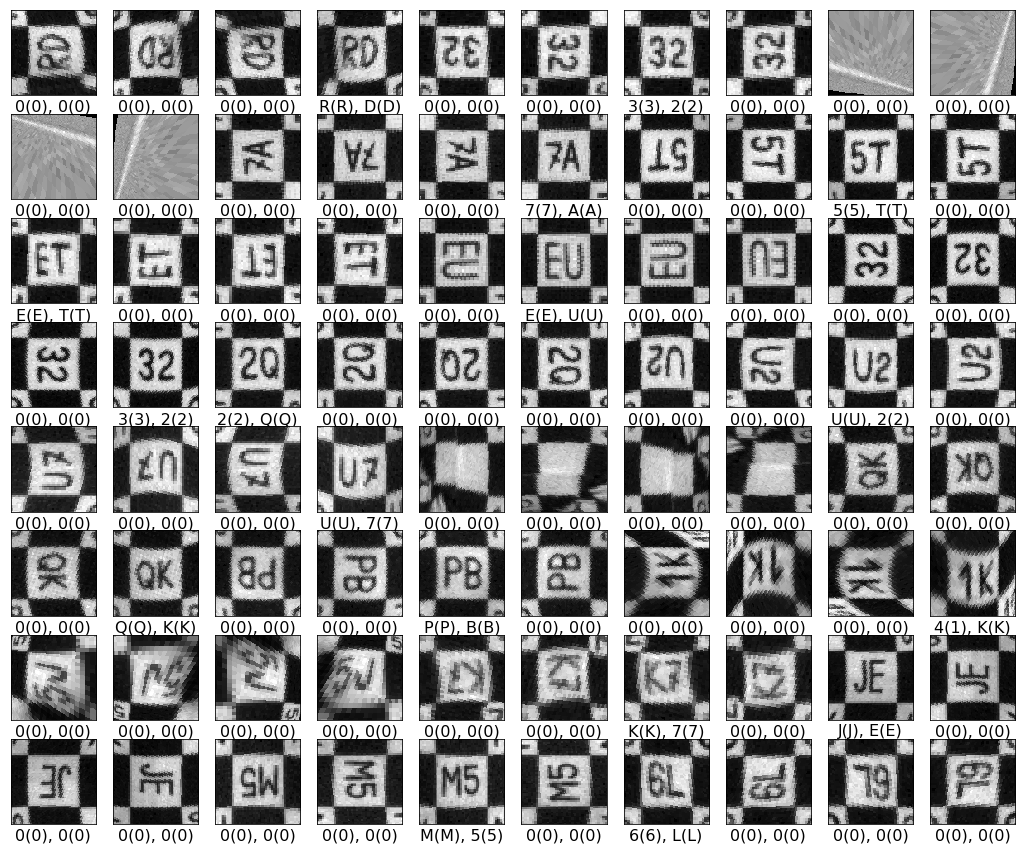

In [47]:
# visualize the predictions
offset = 80
plt.figure(figsize=(18,15))
for i in range(10*8):
    plt.subplot(8,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)    
    plt.imshow(test_images[offset + i, :, :, 0], cmap=plt.cm.gray)
    #plt.xlabel(str(t_predictions1[offset + i]) + ", " + str(t_predictions2[offset + i])) 
    plt.xlabel("%s(%s), %s(%s)" % (inv_ext_suit_dict[t_predictions1[offset + i]-1], inv_ext_suit_dict[test_labels1[offset + i]-1],
                                   inv_ext_suit_dict[t_predictions2[offset + i]-1], inv_ext_suit_dict[test_labels2[offset + i]-1]), fontsize = 16)

In [48]:
# select incorrect predictions
err_imgs = []
err_str = []
for i in range(test_images.shape[0]):    
    if t_predictions1[i] == test_labels1[i] and t_predictions2[i] == test_labels2[i]:
        None
    else:
        err_imgs.append(test_images[i, :, :, 0])
        err_str.append("%s(%s), %s(%s)" % (inv_ext_suit_dict[t_predictions1[i]-1], inv_ext_suit_dict[test_labels1[i]-1], 
                                           inv_ext_suit_dict[t_predictions2[i]-1], inv_ext_suit_dict[test_labels2[i]-1]))
print(len(err_imgs))

31


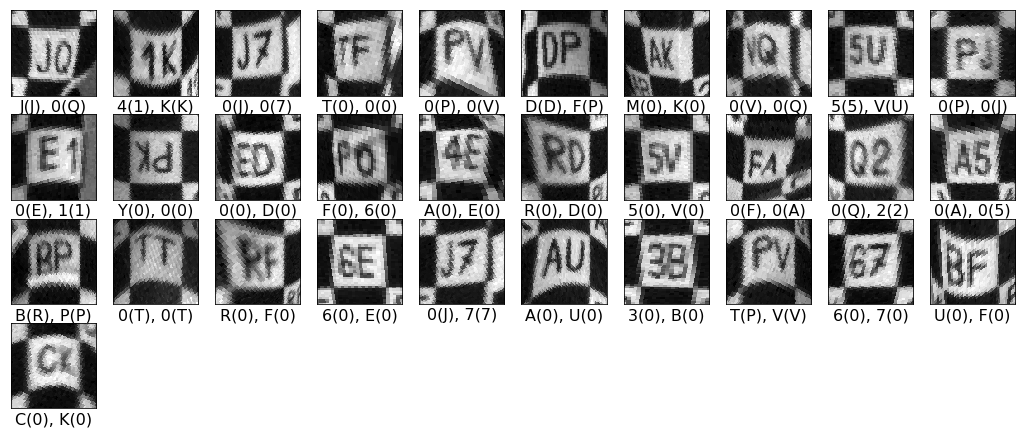

In [49]:
# visualize them
plt.figure(figsize=(18,15))
for i in range(len(err_imgs)):
    plt.subplot(8,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)    
    plt.imshow(err_imgs[i], cmap=plt.cm.gray)    
    plt.xlabel(err_str[i], fontsize = 16)

In [50]:
saver = tf.train.Saver()
save_path = saver.save(sess, "./nets/CNN_2char_bn_unified.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: ./nets/CNN_2char_bn_unified.ckpt


In [51]:
sess.close()